In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
"""
This is a test of spectra generation with pspy and namaster for spin0 fields.
It is done in HEALPIX pixellisation
"""
import matplotlib
from pspy import so_map,so_window,so_mcm,sph_tools,so_spectra, pspy_utils
import healpy as hp, numpy as np, pylab as plt
import os
import pymaster as nmt

## Generate Maps/Masks, Compute NaMaster

In [4]:
#We  specify the HEALPIX survey parameter, it will be a disk of radius 25 degree centered on longitude 30 degree and latitude 50 degree
# It will have a resolution nside=1024
lon,lat=30,50
radius=100
nside=1024
# ncomp=1 mean that we are going to use only spin0 field (ncomp=3 for spin 0 and 2 fields
ncomp=1
# clfile are the camb lensed power spectra
clfile='../../data/bode_almost_wmap5_lmax_1e4_lensedCls_startAt2.dat'
# a binningfile with format, lmin,lmax,lmean
binning_file='../../data/binningFile_100_50.dat'
# the maximum multipole to consider
lmax=3*nside-1
# the number of iteration in map2alm
niter=3
# the noise on the spin0 component
rms_uKarcmin_T=20
# the apodisation lengh for the survey mask (in degree)
apo_radius_degree_survey=1
# the number of holes in the point source mask
source_mask_nholes=100
# the radius of the holes (in arcminutes)
source_mask_radius=10
# the apodisation lengh for the point source mask (in degree)
apo_radius_degree_mask=0.3
# the type of power spectrum (Cl or Dl)
type='Cl'

test_dir='result_pspyVSnamaster_spin0'
try:
    os.makedirs(test_dir)
except:
    pass

# the templates for the CMB splits
template= so_map.healpix_template(ncomp,nside=nside)
# the templates for the binary mask
binary=so_map.healpix_template(ncomp=1,nside=nside)
# we set pixel inside the disk at 1 and pixel outside at zero
vec=hp.pixelfunc.ang2vec(lon,lat, lonlat=True)
disc=hp.query_disc(nside, vec, radius=radius*np.pi/180)
binary.data[disc]=1

#First let's generate a CMB realisation
cmb=template.synfast(clfile)
split=cmb.copy()
#let's add noise to it with rms 20 uk.arcmin
noise = so_map.white_noise(split,rms_uKarcmin_T=rms_uKarcmin_T)
split.data+=noise.data

#we then apodize the survey mask
window=so_window.create_apodization(binary, apo_type='C1', apo_radius_degree=apo_radius_degree_survey)
#we create a point source mask
mask=so_map.simulate_source_mask(binary, nholes=source_mask_nholes, hole_radius_arcmin=source_mask_radius)
#... and we apodize it
mask= so_window.create_apodization(mask, apo_type='C1', apo_radius_degree=apo_radius_degree_mask)
#the window is given by the product of the survey window and the mask window
window.data*=mask.data


binleft, binright = np.genfromtxt('Planck_data/binused.dat', 
                                          unpack=True, usecols=(0,1), dtype=((int), (int)))

binleft, binright = binleft, binright
ells = np.arange(3*nside)
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
weights = np.array([1 for l in ells])
b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=False)
lb = b.get_effective_ells()


# Compute spin 0 spectra a la namaster
# nlb=50
field=nmt.NmtField(window.data,[split.data])
cl_coupled=nmt.compute_coupled_cell(field,field)
# b=nmt.NmtBin(nside,nlb=nlb)
# lb=b.get_effective_ells()
w0=nmt.NmtWorkspace()
w0.compute_coupling_matrix(field,field,b)
Cb_namaster=w0.decouple_cell(cl_coupled)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


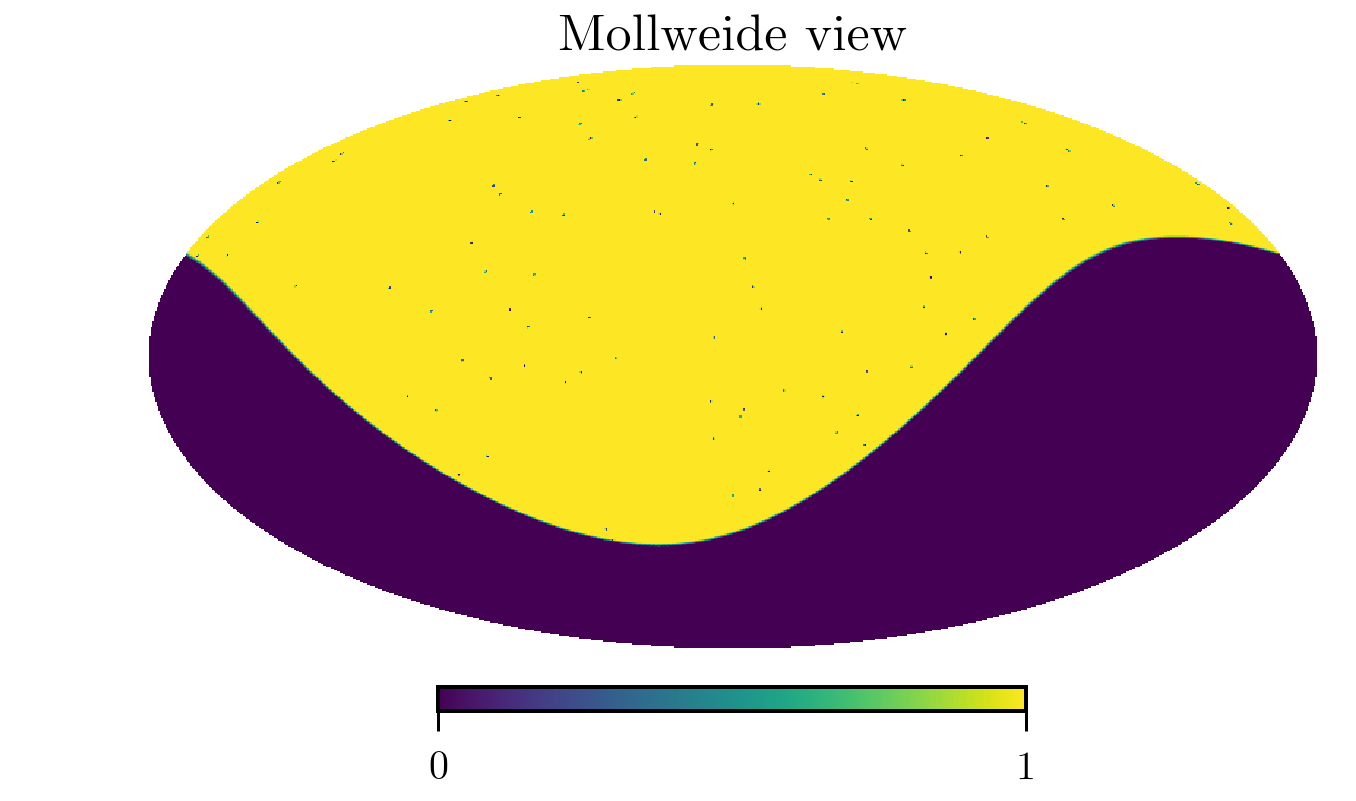

In [14]:
hp.mollview(window.data)

In [5]:
import ispice

In [6]:
hp.write_map('window.fits', window.data, overwrite=True)
hp.write_map('split.fits', split.data, overwrite=True)

In [7]:
ispice.ispice(mapin1='split.fits',  maskfile1='window.fits',
              mapfile2='split.fits',  maskfile2='window.fits', 
              apodizesigma=180, thetamax=180,
              clout='cl.fits')

Submitting job 0
/home/zequnl/Installs/PolSpice_v03-05-01/bin/./spice -apodizesigma 180 -apodizetype 0 -beam NO -beam2 NO -clfile cl.fits -decouple NO -mapfile split.fits -mapfile2 split.fits -fits_out YES -maskfile window.fits -maskfile2 window.fits -nlmax -1 -normfac 1.00000 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav NO -subdipole NO -symmetric_cl NO -thetamax 180 -tolerance NO -verbosity 2 -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 


0

In [8]:
from astropy.io import fits
pixwin = hp.sphtfunc.pixwin(nside)
rawcl = fits.open('cl.fits')[1].data['TT'] * pixwin**2

Have to bin it ourselves...

In [9]:
binleft, binright = np.genfromtxt('Planck_data/binused.dat', 
                                          unpack=True, usecols=(0,1), dtype=((int), (int)))

binleft, binright = binleft, binright
ells = np.arange(len(rawcl))
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
    
binned_ell = np.array([ np.sum(ells[bpws==bp])/np.sum(bpws==bp)
                       for bp in range(len(binleft)) ])

Cb_polspice = np.array([ np.sum(
        rawcl[bpws==bp]) / np.sum(bpws==bp) 
                          for bp in range(len(binleft)) ])

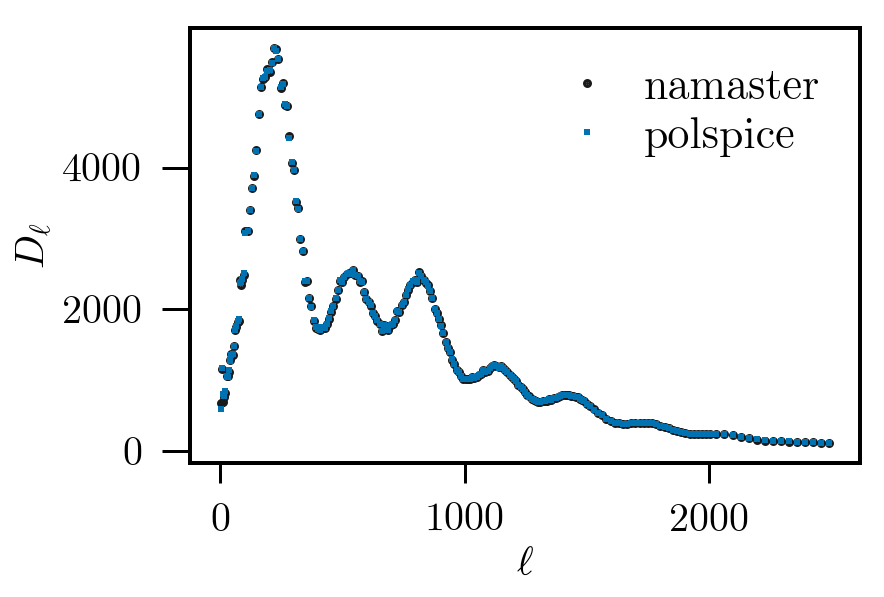

In [12]:
plt.plot(lb,Cb_namaster[0]*lb**2/(2*np.pi),'.',label='namaster')
plt.plot(binned_ell,Cb_polspice*binned_ell**2/(2*np.pi), '.', marker='+', label='polspice')
plt.ylabel(r'$D_{\ell}$',fontsize=20)
plt.xlabel(r'$\ell$',fontsize=20)
plt.legend()

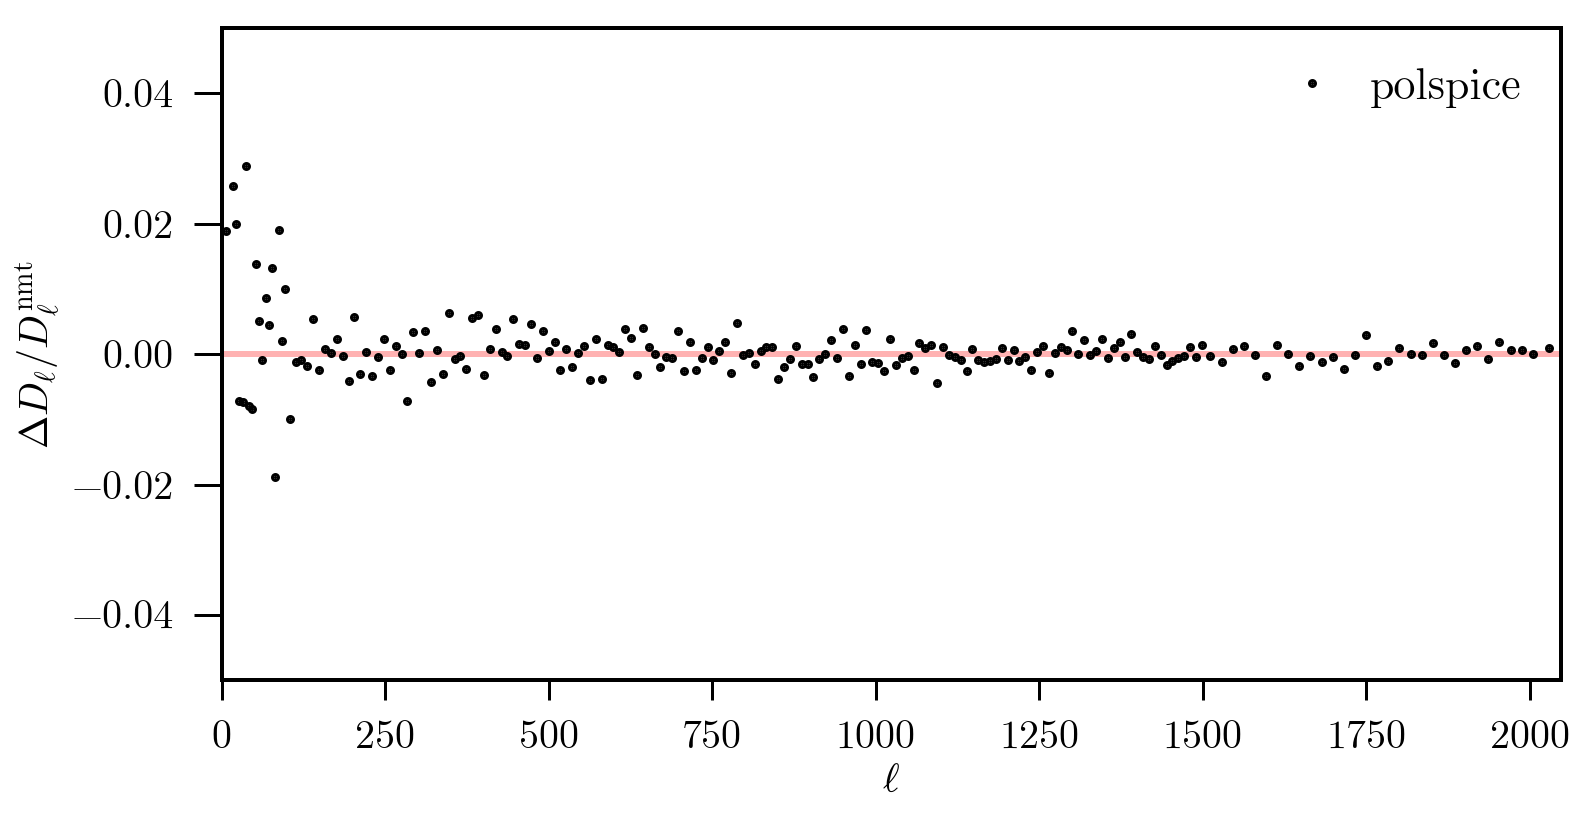

In [13]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
# plot the fractional difference
# plt.plot(lb_pspy,(Cb_pspy-Cb_namaster[0][:100])/Cb_namaster[0][:100], label='pspy')
plt.ylabel(r'$\Delta D_{\ell}/D^{\rm nmt}_{\ell}$',fontsize=20)
plt.xlabel(r'$\ell$',fontsize=20)

# plot the fractional difference
plt.plot(lb,(Cb_polspice-Cb_namaster[0])/Cb_namaster[0], 'k.', label='polspice')

plt.xlim(0,2048)
plt.ylim(-0.05, 0.05)
plt.legend()